<h1 align='center'> Monte-Carlo (MCMC)  </h1>


In [11]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import quad

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$ 
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.

1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

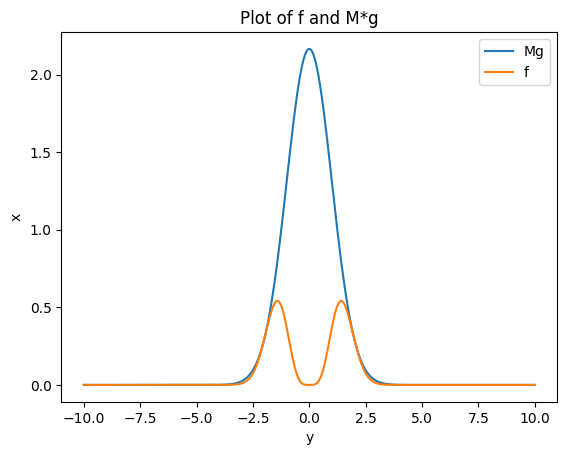

In [12]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)

def empirical_M(f,g,x):
    #We find M empirically as supp(f/g) over x
    return np.max(np.array([f(x_i)/g(x_i) for x_i in x]))

M=empirical_M(f,g,x)
plt.plot(x,M*g(x),label='Mg')
plt.plot(x,f(x),label='f')
plt.xlabel('y')
plt.ylabel('x')
plt.title('Plot of f and M*g')
plt.legend()
plt.show()


2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

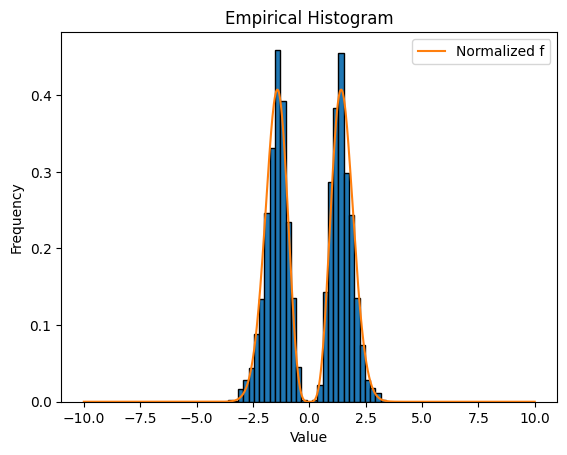

In [13]:
def rejection_sampling(f,g,x,N):
    """Reject sampling algorithm for f with Gaussian proposal g."""
    X=np.random.normal(0,1,N)
    U=np.random.uniform(0,1,N)
    C_f,_=quad(f,-np.inf,np.inf)
    f_norm  = lambda x: f(x)/C_f
    M=empirical_M(f_norm,g,x)
    accepted_sample=[]
    for i in range(N):
        if U[i]<=f(X[i])/(M*g(X[i])):
            accepted_sample.append(X[i])
    return np.array(accepted_sample),f_norm

accepted_sample,f_norm=rejection_sampling(f,g,x,10000)
# Plotting the histogram
plt.hist(accepted_sample, density=True, bins=30, edgecolor='black')
plt.plot(x,f_norm(x),label='Normalized f')
# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Empirical Histogram')
# Display the plot
plt.legend()
plt.show()




3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

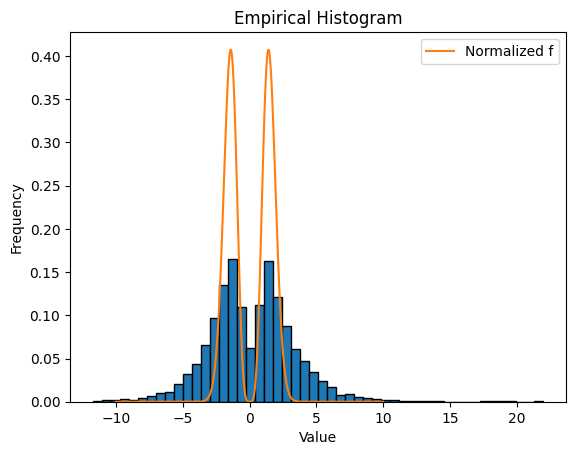

In [14]:
def rw_metropolis_hastings(n, f=f, seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """
    if seed==None:
        seed=0
    MC=[seed]
    for i in range(n):
        x=MC[-1]
        y=np.random.normal(x)
        u=np.random.uniform(-1,1)
        if f(x)==0 or u<=f(y)/f(x):
            MC.append(y)
        else:
            MC.append(x)
    return np.array(MC)

x = np.linspace(-10, 10, 1000)
n=20000
MC=rw_metropolis_hastings(n, f)
# Plotting the histogram
plt.hist(MC, density=True, bins=50, edgecolor='black')
plt.plot(x,f_norm(x),label='Normalized f')
# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Empirical Histogram')
plt.legend()
# Display the plot
plt.show()


# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

The parameter of the distribution is $\rho$
$$p(x_1 , x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$

Using $p(x_1,x_2)= p(x_1|x_2)p(x_2)$ we easily get : 

$X_1 | X_2 \sim \mathcal{N}(\rho X_2,\,1-\rho^2) $

Since the role of $X_1$ and $X_2$ are symmetric : 

$X_2 | X_1 \sim \mathcal{N}(\rho X_1,\,1-\rho^2) $

*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [15]:
def gibbs_sampler(rho,n):
    """Gibbs sampler for (X_1, X_2)."""
    X=[[0,0]]
    var=1-rho**2
    for i in range(n-1):
        x1,x2=X[-1]
        y1=np.random.normal(rho*x2,var)
        y2=np.random.normal(rho*y1,var)
        X.append([y1,y2])
    return np.array(X)

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

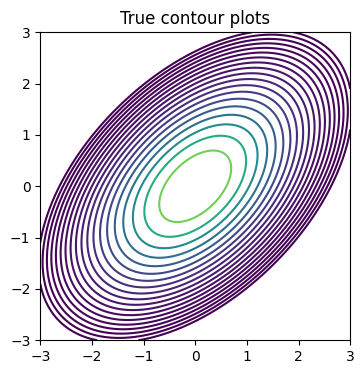

In [16]:
from scipy.stats import multivariate_normal
rho = 0.5
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(4, 4))
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")
plt.show()

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

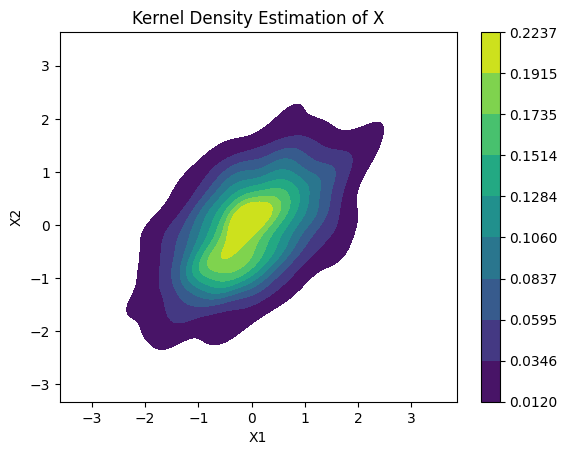

In [17]:
n=1000
X=gibbs_sampler(rho,n)
X1=X[:,0]
X2=X[:,1]
import seaborn as sns
sns.kdeplot(x=X[:, 0],y=X[:, 1], cmap='viridis', fill=True, cbar=True)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Kernel Density Estimation of X')
plt.show()


4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

In [18]:
np.corrcoef(X1,X2)

array([[1.       , 0.5344222],
       [0.5344222, 1.       ]])

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

In [19]:
#We could add seed value to see the evolution of our random variable for different seed value, knowing their correlation rho

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$. 

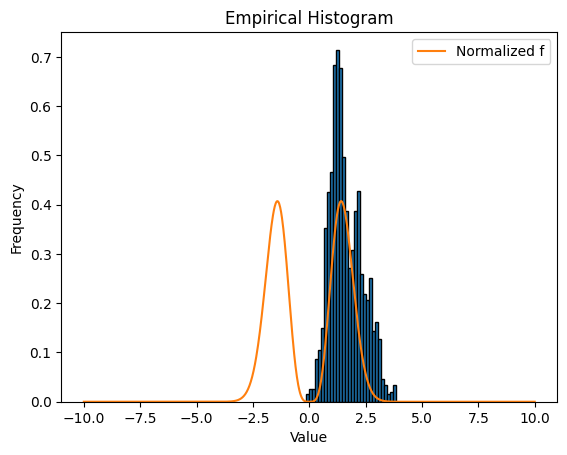

In [20]:
def rw_metropolis_hastings(n, f, tau=1., seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g."""
    if seed==None:
        seed=0
    MC=[seed]
    for i in range(n):
        x=MC[-1]
        y=np.random.normal(x,tau)
        u=np.random.uniform(-1,1)
        if f(x)==0 or u<=f(y)/f(x):
            MC.append(y)
        else:
            MC.append(x)
    return np.array(MC)

x = np.linspace(-10, 10, 1000)
n=2000
MC_t=rw_metropolis_hastings(n, f,tau=0.1)
# Plotting the histogram
plt.hist(MC_t, density=True, bins=30, edgecolor='black')
plt.plot(x,f_norm(x),label='Normalized f')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Empirical Histogram')
plt.legend()
# Display the plot
plt.show()

#We can see that in general, for low value of tau, the chain tends to be 'stuck' on one of the lobe of f.